# Double-diSPIM Processing Pipeline

This notebook implements the complete processing pipeline to transform raw double-diSPIM data into a single, isotropic, high-resolution 3D volume.

## Pipeline Overview

1. **Deskewing**: Remove 45° shear from light sheet imaging
2. **Intra-Arm Alignment**: Align cameras within each arm (Alpha: A↔B, Beta: C↔D)
3. **Rough Inter-Arm Alignment**: Transform Beta arm to match Alpha coordinate system
4. **Fine Registration**: Precise alignment of Beta to Alpha using overlapping regions
5. **Fusion**: Combine all 4 registered volumes into single isotropic volume

## System Geometry

- **Alpha Arm (Top)**: Views from above, imaging XZ plane
- **Beta Arm (Bottom)**: Views from below, rotated 90° around Z-axis, imaging YZ plane
- Each arm has 2 cameras that need spatial alignment


## Section 1: Setup and Imports


In [1]:
# NumPy 2.0 compatibility: Some libraries (xarray, dask, SimpleITK) may use deprecated np.unicode_
# Add compatibility shim immediately after importing numpy, before other imports
import numpy as np
if not hasattr(np, 'unicode_'):
    np.unicode_ = np.str_

import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import data loading functions
from utils import (
    parse_metadata,
    load_ome_tiff,
    discover_acquisitions,
    extract_spatial_info,
    scale_image_for_display,
    create_camera_overlay
)

# Import processing functions
from processing import (
    deskew_stack,
    calculate_deskew_matrix,
    rough_align_beta_to_alpha,
    flip_z_axis,
    rotate_xy_90deg,
    align_cameras_within_arm,
    register_arms,
    apply_transform,
    fuse_volumes,
    compute_mip,
    compute_mip_xyz,
    # Save/load functions
    save_deskewed_stack,
    load_deskewed_stack,
    check_deskewed_exists,
    get_deskewed_paths,
    save_processed_stack,
    load_processed_stack,
    check_processed_exists,
    get_aligned_camera_paths,
    get_rough_aligned_paths,
    get_registered_paths,
    get_fused_paths
)

# Set up matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")


Libraries imported successfully!


## Section 2: Load Data and Define Parameters


In [2]:
# Discover acquisitions
acquisitions = discover_acquisitions('./datasets')
print(f"Found {len(acquisitions)} acquisition pairs")

# Select acquisition to process
ACQUISITION_INDEX = 0

if len(acquisitions) > ACQUISITION_INDEX:
    selected_acq = acquisitions[ACQUISITION_INDEX]
    print(f"\nSelected: {selected_acq['condition']}/{selected_acq['run']}")
else:
    print(f"Error: Acquisition index {ACQUISITION_INDEX} not available")
    selected_acq = None


Found 9 acquisition pairs

Selected: 10msec_worm/I


In [3]:
# Load metadata
if selected_acq:
    alpha_meta = parse_metadata(selected_acq['alpha_metadata'])
    beta_meta = parse_metadata(selected_acq['beta_metadata'])
    
    # Extract key parameters for processing
    pixel_size_um = extract_spatial_info(alpha_meta, beta_meta)['pixel_size_um']['average']
    z_step_um = extract_spatial_info(alpha_meta, beta_meta)['z_step_um']['average']
    
    print(f"Processing parameters:")
    print(f"  Pixel size: {pixel_size_um:.4f} μm")
    print(f"  Z-step: {z_step_um:.4f} μm")
    print(f"  Light sheet angle: 45° (standard for diSPIM)")
    
    # Configuration for saving/loading intermediate results
    OUTPUT_DIR = Path('./processed_output')  # Base directory for saved results
    SAVE_INTERMEDIATES = True  # Set to True to save all intermediate results
    
    # Force flags: Set to True to force re-processing even if files exist
    FORCE_REDESKEW = False      # Force re-deskewing
    FORCE_ALIGNMENT = False      # Force re-alignment (intra-arm)
    FORCE_ROUGH_ALIGN = False   # Force rough inter-arm alignment
    FORCE_REGISTRATION = False  # Force fine registration
    FORCE_FUSION = False        # Force re-fusion
    
    # For testing, you may want to load a subset of slices
    # Set to None to load full stack
    MAX_SLICES_FOR_PROCESSING = None  # Change to smaller number (e.g., 50) for faster testing
    
    print(f"\nLoading image data...")
    print(f"  Max slices: {MAX_SLICES_FOR_PROCESSING if MAX_SLICES_FOR_PROCESSING else 'All'}")
    
    # Load all cameras from both arms
    alpha_data = load_ome_tiff(
        selected_acq['alpha_tiff'],
        metadata=alpha_meta,
        channel_idx=None,  # Load all cameras
        max_slices=MAX_SLICES_FOR_PROCESSING
    )
    
    beta_data = load_ome_tiff(
        selected_acq['beta_tiff'],
        metadata=beta_meta,
        channel_idx=None,  # Load all cameras
        max_slices=MAX_SLICES_FOR_PROCESSING
    )
    
    print(f"\nData loaded:")
    print(f"  Alpha shape: {alpha_data.shape}")
    print(f"  Beta shape: {beta_data.shape}")
    print(f"  Alpha cameras: {alpha_meta['channel_names']}")
    print(f"  Beta cameras: {beta_meta['channel_names']}")
    
    # Create acquisition name for file paths
    acquisition_name = f"{selected_acq['condition']}_{selected_acq['run']}"
else:
    print("No acquisition selected")
    alpha_data = None
    beta_data = None
    OUTPUT_DIR = None
    SAVE_INTERMEDIATES = True
    FORCE_REDESKEW = False
    FORCE_ALIGNMENT = False
    FORCE_ROUGH_ALIGN = False
    FORCE_REGISTRATION = False
    FORCE_FUSION = False
    acquisition_name = None


Processing parameters:
  Pixel size: 0.1220 μm
  Z-step: 0.7000 μm
  Light sheet angle: 45° (standard for diSPIM)

Loading image data...
  Max slices: All
Loading OME-TIFF: datasets/10msec_worm/I/beads_alpha_worm2_4/beads_alpha_worm2_MMStack_Pos0.ome.tif
Raw data shape: (200, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (200, 2, 2304, 2304)
Loading OME-TIFF: datasets/10msec_worm/I/beads_beta_worm2_4/beads_beta_worm2_MMStack_Pos0.ome.tif
Raw data shape: (200, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (200, 2, 2304, 2304)

Data loaded:
  Alpha shape: (200, 2, 2304, 2304)
  Beta shape: (200, 2, 2304, 2304)
  Alpha cameras: ['HamCam2', 'HamCam1']
  Beta cameras: ['HamuHam4', 'HamuHam3']


## Phase 1: Deskewing

Remove the 45° shear from the raw light sheet data. Each camera stack is deskewed independently.

**Note on Save/Load**: Deskewed results are automatically saved to `processed_output/` and will be loaded on subsequent runs to avoid re-running this time-intensive step. To force re-deskewing, set `FORCE_REDESKEW = True` in the configuration cell above.


In [4]:
if alpha_data is not None and beta_data is not None:
    print("=" * 70)
    print("PHASE 1: DESKEWING")
    print("=" * 70)
    
    # Extract individual camera stacks
    # Alpha arm: cameras 0 and 1
    alpha_cam0_raw = alpha_data[:, 0, :, :]  # Shape: (Z, Y, X)
    alpha_cam1_raw = alpha_data[:, 1, :, :]
    
    # Beta arm: cameras 0 and 1
    beta_cam0_raw = beta_data[:, 0, :, :]
    beta_cam1_raw = beta_data[:, 1, :, :]
    
    # Dictionary to store transform info for all cameras
    deskew_info = {}
    
    # Process Alpha Camera 0
    cam0_name = alpha_meta['channel_names'][0]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam0_name, 'alpha'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Alpha Camera 0 ({cam0_name})...")
        alpha_cam0_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['alpha_cam0'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {alpha_cam0_deskewed.shape}")
    else:
        print(f"\nDeskewing Alpha Camera 0 ({cam0_name})...")
        alpha_cam0_deskewed, info0 = deskew_stack(
            alpha_cam0_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['alpha_cam0'] = info0
        print(f"  Input shape: {info0['input_shape']}")
        print(f"  Output shape: {info0['output_shape']}")
        
        if SAVE_INTERMEDIATES:
            stack_path, meta_path = get_deskewed_paths(
                OUTPUT_DIR, acquisition_name, cam0_name, 'alpha'
            )
            save_deskewed_stack(
                alpha_cam0_deskewed, stack_path, 
                transform_info=info0,
                metadata={'camera': cam0_name, 'arm': 'alpha', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
            )
            print(f"  Saved to: {stack_path}")
    
    # Process Alpha Camera 1
    cam1_name = alpha_meta['channel_names'][1]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam1_name, 'alpha'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Alpha Camera 1 ({cam1_name})...")
        alpha_cam1_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['alpha_cam1'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {alpha_cam1_deskewed.shape}")
    else:
        print(f"\nDeskewing Alpha Camera 1 ({cam1_name})...")
        alpha_cam1_deskewed, info1 = deskew_stack(
            alpha_cam1_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['alpha_cam1'] = info1
        
        if SAVE_INTERMEDIATES:
            stack_path, meta_path = get_deskewed_paths(
                OUTPUT_DIR, acquisition_name, cam1_name, 'alpha'
            )
            save_deskewed_stack(
                alpha_cam1_deskewed, stack_path,
                transform_info=info1,
                metadata={'camera': cam1_name, 'arm': 'alpha', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
            )
            print(f"  Saved to: {stack_path}")
    
    # Process Beta Camera 0
    cam0_name = beta_meta['channel_names'][0]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam0_name, 'beta'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Beta Camera 0 ({cam0_name})...")
        beta_cam0_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['beta_cam0'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {beta_cam0_deskewed.shape}")
    else:
        print(f"\nDeskewing Beta Camera 0 ({cam0_name})...")
        beta_cam0_deskewed, info2 = deskew_stack(
            beta_cam0_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['beta_cam0'] = info2
        print(f"  Input shape: {info2['input_shape']}")
        print(f"  Output shape: {info2['output_shape']}")
        
        if SAVE_INTERMEDIATES:
            stack_path, meta_path = get_deskewed_paths(
                OUTPUT_DIR, acquisition_name, cam0_name, 'beta'
            )
            save_deskewed_stack(
                beta_cam0_deskewed, stack_path,
                transform_info=info2,
                metadata={'camera': cam0_name, 'arm': 'beta', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
            )
            print(f"  Saved to: {stack_path}")
    
    # Process Beta Camera 1
    cam1_name = beta_meta['channel_names'][1]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam1_name, 'beta'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Beta Camera 1 ({cam1_name})...")
        beta_cam1_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['beta_cam1'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {beta_cam1_deskewed.shape}")
    else:
        print(f"\nDeskewing Beta Camera 1 ({cam1_name})...")
        beta_cam1_deskewed, info3 = deskew_stack(
            beta_cam1_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['beta_cam1'] = info3
        
        if SAVE_INTERMEDIATES:
            stack_path, meta_path = get_deskewed_paths(
                OUTPUT_DIR, acquisition_name, cam1_name, 'beta'
            )
            save_deskewed_stack(
                beta_cam1_deskewed, stack_path,
                transform_info=info3,
                metadata={'camera': cam1_name, 'arm': 'beta', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
            )
            print(f"  Saved to: {stack_path}")
    
    print("\nDeskewing complete!")
    print(f"\nNote: Set FORCE_REDESKEW=True to force re-deskewing even if files exist")
else:
    print("No data loaded")


PHASE 1: DESKEWING

Loading existing deskewed Alpha Camera 0 (HamCam2)...
  Loaded shape: (200, 2304, 3452)

Loading existing deskewed Alpha Camera 1 (HamCam1)...
  Loaded shape: (200, 2304, 3452)

Loading existing deskewed Beta Camera 0 (HamuHam4)...
  Loaded shape: (200, 2304, 3452)

Loading existing deskewed Beta Camera 1 (HamuHam3)...
  Loaded shape: (200, 2304, 3452)

Deskewing complete!

Note: Set FORCE_REDESKEW=True to force re-deskewing even if files exist


### Visualize Deskewing Results

Compare raw vs deskewed Maximum Intensity Projections (MIPs) to verify the transformation.


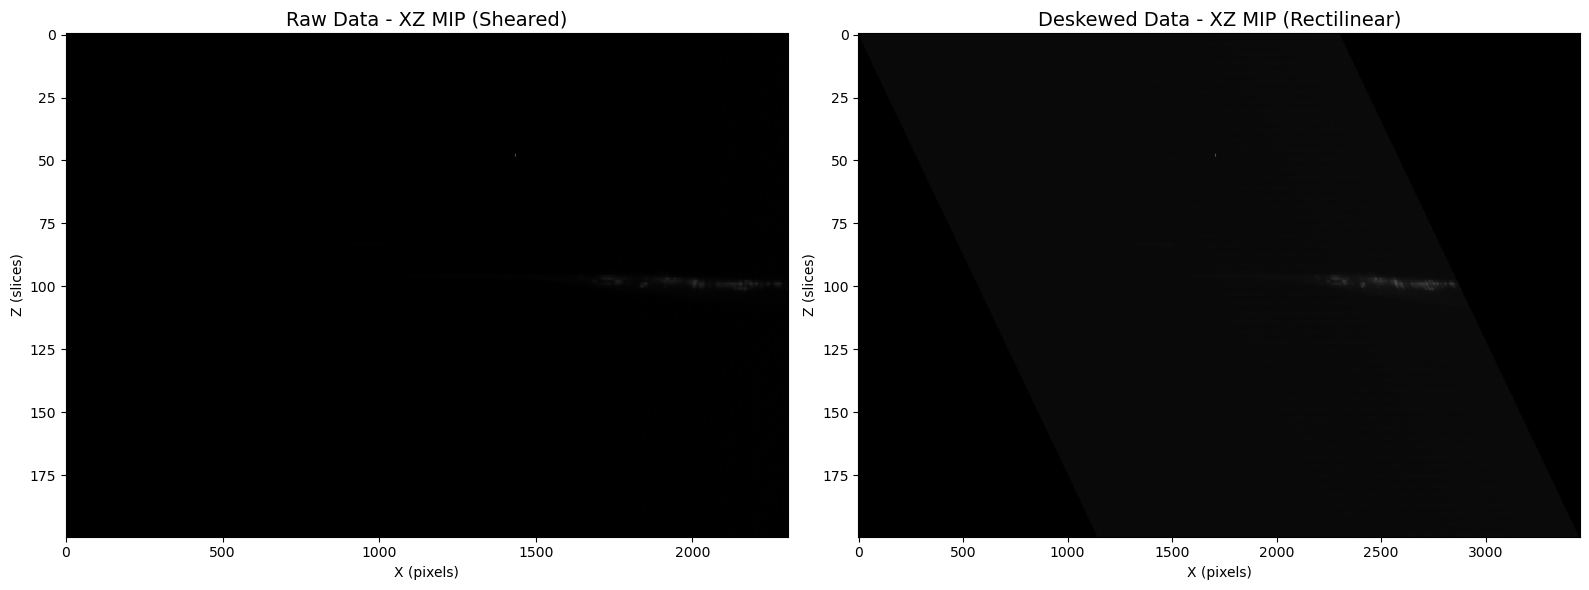


Note: In the deskewed version, spherical objects should appear circular,
not elongated/oval as in the raw sheared data.


In [5]:
if alpha_data is not None:
    # Compute MIPs for visualization
    # XZ view: project along Y axis
    alpha_cam0_raw_xz = compute_mip(alpha_cam0_raw, axis=1)
    alpha_cam0_deskewed_xz = compute_mip(alpha_cam0_deskewed, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw XZ MIP
    raw_scaled, _, _ = scale_image_for_display(alpha_cam0_raw_xz)
    axes[0].imshow(raw_scaled, cmap='gray', aspect='auto')
    axes[0].set_title('Raw Data - XZ MIP (Sheared)', fontsize=14)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Z (slices)')
    
    # Deskewed XZ MIP
    deskewed_scaled, _, _ = scale_image_for_display(alpha_cam0_deskewed_xz)
    axes[1].imshow(deskewed_scaled, cmap='gray', aspect='auto')
    axes[1].set_title('Deskewed Data - XZ MIP (Rectilinear)', fontsize=14)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Z (slices)')
    
    plt.tight_layout()
    plt.show()
    
    print("\nNote: In the deskewed version, spherical objects should appear circular,")
    print("not elongated/oval as in the raw sheared data.")


## Phase 2: Intra-Arm Camera Alignment

Align the two cameras within each arm. This registers cameras that view the same sample from different angles.

**IMPORTANT**: Because the two objectives in a single arm face each other, their cameras capture "mirror images" of the sample in the lateral direction. The alignment function automatically flips the second camera horizontally before registration to account for this.

**Performance Note**: Registration can be time-consuming for large volumes. Consider using `max_slices_for_registration` parameter (e.g., 50-100 slices) for faster testing. SimpleITK does not support GPU acceleration, so this is CPU-based.

**IMPORTANT**: Because the two objectives in a single arm face each other, their cameras capture "mirror images" of the sample in the lateral direction. The alignment function automatically flips the second camera horizontally before registration to account for this.

**Performance Note**: Registration can be time-consuming for large volumes. For faster testing, you can use `max_slices_for_registration` parameter to register on a subset of slices, then apply the transform to the full stack.


In [ ]:
if alpha_data is not None:
    print("=" * 70)
    print("PHASE 2: INTRA-ARM CAMERA ALIGNMENT")
    print("=" * 70)
    
    # Alpha arm: align camera 1 to camera 0
    cam1_name = alpha_meta['channel_names'][1]
    exists, stack_path, meta_path = check_processed_exists(
        OUTPUT_DIR, acquisition_name, 'aligned', f"alpha_{cam1_name}_aligned"
    )
    
    if exists and not FORCE_ALIGNMENT:
        print(f"\nLoading existing aligned Alpha Camera 1 ({cam1_name})...")
        alpha_cam1_aligned, loaded_meta = load_processed_stack(stack_path)
        print(f"  Loaded shape: {alpha_cam1_aligned.shape}")
        # Note: transform and metrics not saved, would need to re-run to get them
        alpha_transform = None
        alpha_metrics = {}
    else:
        print(f"\nAligning Alpha cameras: {cam1_name} -> {alpha_meta['channel_names'][0]}")
        print("This may take several minutes...")
        
        # For faster testing, you can use max_slices_for_registration parameter
        # e.g., max_slices_for_registration=50 to register on first 50 slices only
        alpha_cam1_aligned, alpha_transform, alpha_metrics = align_cameras_within_arm(
            alpha_cam0_deskewed,  # Fixed (reference)
            alpha_cam1_deskewed,  # Moving (to be aligned)
            transform_type='rigid',
            verbose=True,
            flip_cam1_horizontal=True,  # Account for mirror image relationship
            max_slices_for_registration=None  # Use None for full stack, or e.g., 50 for faster testing
        )
        
        print(f"\nAlpha alignment metrics:")
        print(f"  Final metric value: {alpha_metrics['final_metric_value']:.6f}")
        print(f"  Iterations: {alpha_metrics['optimizer_iterations']}")
        
        if SAVE_INTERMEDIATES:
            stack_path, meta_path = get_aligned_camera_paths(
                OUTPUT_DIR, acquisition_name, cam1_name, 'alpha'
            )
            save_processed_stack(
                alpha_cam1_aligned, stack_path,
                metadata={'camera': cam1_name, 'arm': 'alpha', 'metrics': alpha_metrics}
            )
            print(f"  Saved to: {stack_path}")
    
    # Beta arm: align camera 1 to camera 0
    cam1_name = beta_meta['channel_names'][1]
    exists, stack_path, meta_path = check_processed_exists(
        OUTPUT_DIR, acquisition_name, 'aligned', f"beta_{cam1_name}_aligned"
    )
    
    if exists and not FORCE_ALIGNMENT:
        print(f"\nLoading existing aligned Beta Camera 1 ({cam1_name})...")
        beta_cam1_aligned, loaded_meta = load_processed_stack(stack_path)
        print(f"  Loaded shape: {beta_cam1_aligned.shape}")
        beta_transform = None
        beta_metrics = {}
    else:
        print(f"\nAligning Beta cameras: {cam1_name} -> {beta_meta['channel_names'][0]}")
        print("This may take several minutes...")
        
        beta_cam1_aligned, beta_transform, beta_metrics = align_cameras_within_arm(
            beta_cam0_deskewed,  # Fixed (reference)
            beta_cam1_deskewed,  # Moving (to be aligned)
            transform_type='rigid',
            verbose=True,
            flip_cam1_horizontal=True,  # Account for mirror image relationship
            max_slices_for_registration=None  # Use None for full stack, or e.g., 50 for faster testing
        )
        
        print(f"\nBeta alignment metrics:")
        print(f"  Final metric value: {beta_metrics['final_metric_value']:.6f}")
        print(f"  Iterations: {beta_metrics['optimizer_iterations']}")
        
        if SAVE_INTERMEDIATES:
            stack_path, meta_path = get_aligned_camera_paths(
                OUTPUT_DIR, acquisition_name, cam1_name, 'beta'
            )
            save_processed_stack(
                beta_cam1_aligned, stack_path,
                metadata={'camera': cam1_name, 'arm': 'beta', 'metrics': beta_metrics}
            )
            print(f"  Saved to: {stack_path}")
    
    print("\nIntra-arm alignment complete!")
    print(f"\nNote: Set FORCE_ALIGNMENT=True to force re-alignment even if files exist")
else:
    print("No data loaded")


PHASE 2: INTRA-ARM CAMERA ALIGNMENT

Aligning Alpha cameras: HamCam1 -> HamCam2
This may take several minutes...
  Applied horizontal flip to cam1 to account for mirror image relationship
Starting registration...
  (This may take several minutes for large volumes)


### Visualize Camera Alignment

Show before/after camera overlays to verify improved alignment.


In [ ]:
if alpha_data is not None:
    # Select a slice in the middle of the volume
    slice_idx = alpha_cam0_deskewed.shape[0] // 2
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Alpha: Before alignment
    alpha_before = create_camera_overlay(
        alpha_cam0_deskewed[slice_idx, :, :],
        alpha_cam1_deskewed[slice_idx, :, :],
        alpha_meta['channel_names'][0],
        alpha_meta['channel_names'][1]
    )
    axes[0, 0].imshow(alpha_before, aspect='equal')
    axes[0, 0].set_title(f'Alpha: Before Alignment (Slice {slice_idx})', fontsize=12)
    axes[0, 0].axis('off')
    
    # Alpha: After alignment
    alpha_after = create_camera_overlay(
        alpha_cam0_deskewed[slice_idx, :, :],
        alpha_cam1_aligned[slice_idx, :, :],
        alpha_meta['channel_names'][0],
        alpha_meta['channel_names'][1]
    )
    axes[0, 1].imshow(alpha_after, aspect='equal')
    axes[0, 1].set_title(f'Alpha: After Alignment (Slice {slice_idx})', fontsize=12)
    axes[0, 1].axis('off')
    
    # Beta: Before alignment
    beta_before = create_camera_overlay(
        beta_cam0_deskewed[slice_idx, :, :],
        beta_cam1_deskewed[slice_idx, :, :],
        beta_meta['channel_names'][0],
        beta_meta['channel_names'][1]
    )
    axes[1, 0].imshow(beta_before, aspect='equal')
    axes[1, 0].set_title(f'Beta: Before Alignment (Slice {slice_idx})', fontsize=12)
    axes[1, 0].axis('off')
    
    # Beta: After alignment
    beta_after = create_camera_overlay(
        beta_cam0_deskewed[slice_idx, :, :],
        beta_cam1_aligned[slice_idx, :, :],
        beta_meta['channel_names'][0],
        beta_meta['channel_names'][1]
    )
    axes[1, 1].imshow(beta_after, aspect='equal')
    axes[1, 1].set_title(f'Beta: After Alignment (Slice {slice_idx})', fontsize=12)
    axes[1, 1].axis('off')
    
    plt.suptitle('Camera Alignment: Red = Camera 0, Green = Camera 1, Yellow = Overlap',
                 fontsize=14)
    plt.tight_layout()
    plt.show()


## Phase 3: Rough Inter-Arm Alignment

Transform Beta arm volumes to roughly match Alpha arm coordinate system:
1. Flip Z-axis (Beta views from below)
2. Rotate 90° in XY plane (Beta arm rotated 90° around Z-axis)


In [ ]:
if alpha_data is not None:
    print("=" * 70)
    print("PHASE 3: ROUGH INTER-ARM ALIGNMENT")
    print("=" * 70)
    
    # Apply rough alignment to Beta cameras
    print("\nApplying rough alignment to Beta Camera 0...")
    beta_cam0_rough, rough_info0 = rough_align_beta_to_alpha(beta_cam0_deskewed)
    
    print("\nApplying rough alignment to Beta Camera 1...")
    beta_cam1_rough, rough_info1 = rough_align_beta_to_alpha(beta_cam1_aligned)
    
    print("\nRough alignment complete!")
    print(f"  Beta Camera 0 shape: {beta_cam0_rough.shape}")
    print(f"  Beta Camera 1 shape: {beta_cam1_rough.shape}")
else:
    print("No data loaded")


### Visualize Rough Alignment

Compare Alpha and Beta volumes after rough alignment to verify they're in the same orientation.


In [ ]:
if alpha_data is not None:
    # Create fused volumes for visualization
    alpha_fused_rough = (alpha_cam0_deskewed + alpha_cam1_aligned) / 2.0
    beta_fused_rough = (beta_cam0_rough + beta_cam1_rough) / 2.0
    
    # Compute MIPs
    alpha_mip_xy = compute_mip(alpha_fused_rough, axis=0)  # XY view
    beta_mip_xy = compute_mip(beta_fused_rough, axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    alpha_scaled, _, _ = scale_image_for_display(alpha_mip_xy)
    axes[0].imshow(alpha_scaled, cmap='gray', aspect='equal')
    axes[0].set_title('Alpha Arm - XY MIP (After Deskewing & Intra-Arm Alignment)', fontsize=12)
    axes[0].axis('off')
    
    beta_scaled, _, _ = scale_image_for_display(beta_mip_xy)
    axes[1].imshow(beta_scaled, cmap='gray', aspect='equal')
    axes[1].set_title('Beta Arm - XY MIP (After Rough Alignment)', fontsize=12)
    axes[1].axis('off')
    
    plt.suptitle('Rough Alignment: Both arms should now be in same orientation', fontsize=14)
    plt.tight_layout()
    plt.show()


## Phase 4: Fine Registration (Inter-Arm)

Perform precise registration of Beta arm to Alpha arm using overlapping regions.


In [ ]:
if alpha_data is not None:
    print("=" * 70)
    print("PHASE 4: FINE INTER-ARM REGISTRATION")
    print("=" * 70)
    
    # Create fused volumes for registration
    alpha_fused = (alpha_cam0_deskewed + alpha_cam1_aligned) / 2.0
    beta_fused = (beta_cam0_rough + beta_cam1_rough) / 2.0
    
    print(f"\nAlpha fused shape: {alpha_fused.shape}")
    print(f"Beta fused shape: {beta_fused.shape}")
    print("\nRegistering Beta to Alpha...")
    print("This may take several minutes...")
    
    beta_fused_registered, inter_arm_transform, inter_metrics = register_arms(
        alpha_fused,  # Fixed (reference)
        beta_fused,  # Moving (to be aligned)
        transform_type='rigid',
        verbose=True
    )
    
    print(f"\nInter-arm registration metrics:")
    print(f"  Final metric value: {inter_metrics['final_metric_value']:.6f}")
    print(f"  Iterations: {inter_metrics['optimizer_iterations']}")
    
    # Apply the same transformation to both Beta cameras
    print("\nApplying transformation to Beta Camera 0...")
    beta_cam0_registered = apply_transform(
        beta_cam0_rough,
        inter_arm_transform,
        reference_shape=alpha_fused.shape
    )
    
    print("Applying transformation to Beta Camera 1...")
    beta_cam1_registered = apply_transform(
        beta_cam1_rough,
        inter_arm_transform,
        reference_shape=alpha_fused.shape
    )
    
    print("\nFine registration complete!")
else:
    print("No data loaded")


### Visualize Final Registration

Show Alpha and Beta volumes overlaid to verify precise alignment.


In [ ]:
if alpha_data is not None:
    # Create overlay of Alpha (red) and Beta (green)
    slice_idx = alpha_fused.shape[0] // 2
    
    # Scale images for display
    alpha_slice_scaled, _, _ = scale_image_for_display(alpha_fused[slice_idx, :, :])
    beta_slice_scaled, _, _ = scale_image_for_display(beta_fused_registered[slice_idx, :, :])
    
    # Create RGB overlay
    overlay = np.zeros((alpha_slice_scaled.shape[0], alpha_slice_scaled.shape[1], 3))
    overlay[:, :, 0] = alpha_slice_scaled  # Red = Alpha
    overlay[:, :, 1] = beta_slice_scaled   # Green = Beta
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    axes[0].imshow(alpha_slice_scaled, cmap='gray', aspect='equal')
    axes[0].set_title('Alpha Arm', fontsize=12)
    axes[0].axis('off')
    
    axes[1].imshow(beta_slice_scaled, cmap='gray', aspect='equal')
    axes[1].set_title('Beta Arm (Registered)', fontsize=12)
    axes[1].axis('off')
    
    axes[2].imshow(overlay, aspect='equal')
    axes[2].set_title('Overlay: Alpha (red) + Beta (green) = Yellow', fontsize=12)
    axes[2].axis('off')
    
    plt.suptitle(f'Final Registration - Slice {slice_idx}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nIn the overlay, yellow regions indicate good alignment.")
    print("Red/green separation indicates remaining misalignment.")


## Phase 5: Fusion

Combine all 4 registered volumes into a single isotropic volume.


In [ ]:
if alpha_data is not None:
    print("=" * 70)
    print("PHASE 5: VOLUME FUSION")
    print("=" * 70)
    
    # Fuse all 4 registered volumes
    print("\nFusing volumes:")
    print(f"  - Alpha Camera 0: {alpha_meta['channel_names'][0]}")
    print(f"  - Alpha Camera 1: {alpha_meta['channel_names'][1]}")
    print(f"  - Beta Camera 0: {beta_meta['channel_names'][0]}")
    print(f"  - Beta Camera 1: {beta_meta['channel_names'][1]}")
    
    fused_volume = fuse_volumes(
        alpha_cam0_deskewed,
        alpha_cam1_aligned,
        beta_cam0_registered,
        beta_cam1_registered,
        method='weighted_average',
        weights=None  # Equal weights for all cameras
    )
    
    print(f"\nFused volume shape: {fused_volume.shape}")
    print(f"Fused volume dtype: {fused_volume.dtype}")
    print(f"Fused volume range: [{fused_volume.min()}, {fused_volume.max()}]")
    
    print("\nFusion complete!")
else:
    print("No data loaded")


### Visualize Fused Volume

Display Maximum Intensity Projections from different views of the fused volume.


In [ ]:
if alpha_data is not None:
    # Compute MIPs from all three views
    mips = compute_mip_xyz(fused_volume)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # XY view (project along Z)
    xy_scaled, _, _ = scale_image_for_display(mips['xy'])
    axes[0].imshow(xy_scaled, cmap='gray', aspect='equal')
    axes[0].set_title('XY View (Z projection)', fontsize=12)
    axes[0].axis('off')
    
    # XZ view (project along Y)
    xz_scaled, _, _ = scale_image_for_display(mips['xz'])
    axes[1].imshow(xz_scaled, cmap='gray', aspect='auto')
    axes[1].set_title('XZ View (Y projection)', fontsize=12)
    axes[1].axis('off')
    
    # YZ view (project along X)
    yz_scaled, _, _ = scale_image_for_display(mips['yz'])
    axes[2].imshow(yz_scaled, cmap='gray', aspect='auto')
    axes[2].set_title('YZ View (X projection)', fontsize=12)
    axes[2].axis('off')
    
    plt.suptitle('Fused Volume - Maximum Intensity Projections', fontsize=14)
    plt.tight_layout()
    plt.show()


## Optional: Save Results

Save the processed volumes for further analysis or visualization in other tools (e.g., Napari, Fiji).


In [ ]:
# Uncomment to save results
# if alpha_data is not None:
#     import tifffile
#     output_dir = Path('processed_output')
#     output_dir.mkdir(exist_ok=True)
#     
#     # Save fused volume
#     output_path = output_dir / f"{selected_acq['condition']}_{selected_acq['run']}_fused.ome.tif"
#     tifffile.imwrite(
#         str(output_path),
#         fused_volume,
#         photometric='minisblack',
#         metadata={'axes': 'ZYX'}
#     )
#     print(f"Saved fused volume to: {output_path}")
#     
#     # Optionally save intermediate results
#     # tifffile.imwrite(output_dir / 'alpha_cam0_deskewed.tif', alpha_cam0_deskewed)
#     # tifffile.imwrite(output_dir / 'beta_cam0_registered.tif', beta_cam0_registered)
#     # etc.


## Summary

### Processing Pipeline Complete!

The pipeline has transformed raw double-diSPIM data through:

1. ✅ **Deskewing**: Removed 45° shear from all 4 camera stacks
2. ✅ **Intra-Arm Alignment**: Aligned cameras within Alpha and Beta arms
3. ✅ **Rough Inter-Arm Alignment**: Transformed Beta to match Alpha coordinate system
4. ✅ **Fine Registration**: Precisely aligned Beta to Alpha
5. ✅ **Fusion**: Combined all volumes into single isotropic volume

### Next Steps

- **Deconvolution**: For even better resolution, apply joint multi-view deconvolution
- **Analysis**: Use the fused volume for segmentation, tracking, or other analysis
- **Visualization**: Load in Napari for interactive 3D exploration

### Notes

- Processing large volumes can be memory-intensive. Consider processing subvolumes or using dask for chunked processing.
- Registration quality can be improved by adjusting SimpleITK parameters (learning rate, iterations, multi-resolution levels).
- For production use, save intermediate results at each phase for debugging and reproducibility.
